In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize

In [2]:
logindf = pd.read_json('logins.json')

In [3]:
logindf.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logindf.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


# Part 1 - Exploratory data analysis

In [5]:
logindf = logindf.sort_values('login_time')
logindf = logindf.reset_index(drop=True)

In [6]:
#aggregate login counts based on 15 minute time intervals
period = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
logins = pd.Series(np.zeros(len(period)), index=period)
x = 0 
for i in range(len(logindf)):
    first = logins.index[x] 
    last = logins.index[x+1] 
    time = logindf['login_time'][i]
    if first < time < last:
        logins[x] = logins[x] + 1
    else:
        while (last < time): 
            x = x + 1 
            first = logins.index[x] 
            last = logins.index[x+1] 
        logins[x] = logins[x] + 1

In [7]:
logins.head()

1970-01-01 20:00:00    2.0
1970-01-01 20:15:00    6.0
1970-01-01 20:30:00    9.0
1970-01-01 20:45:00    7.0
1970-01-01 21:00:00    1.0
Freq: 15T, dtype: float64

In [8]:
logins.tail()

1970-04-13 18:00:00    5.0
1970-04-13 18:15:00    2.0
1970-04-13 18:30:00    7.0
1970-04-13 18:45:00    6.0
1970-04-13 19:00:00    0.0
Freq: 15T, dtype: float64

<AxesSubplot:>

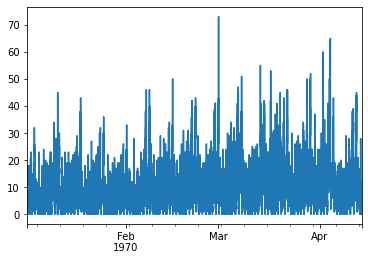

In [9]:
logins.plot()

<AxesSubplot:>

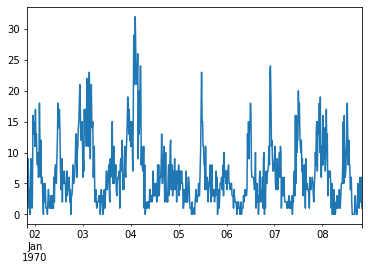

In [10]:
#Visualize for one week, which is the first 4*24*7=672 observations
logins[0:672].plot()

<AxesSubplot:>

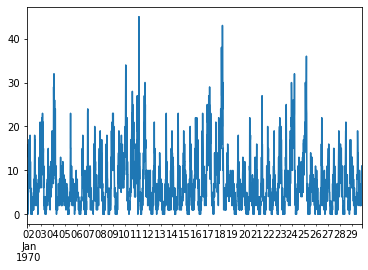

In [11]:
#Visualize for four weeks, which is the first 4*24*28=2688 observations
logins[0:2688].plot()

It looks like there is a consistent spike every 7 days, which corresponds to the weekend.

# Part 2 - Experiments and metric design


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would look at the number of drivers who completed a trip in both cities on the same day during the experiment, and compare that to the number of drivers who completed a trip in both cities on the same day before the experiment. This would tell us if the change had an effect. We could take a separate look at weekdays and weekends to control for that effect.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

As stated above, I would implement an experiment where I would compare the number of drivers who completed a trip in both cities on the same day after eliminating the toll fee with the number of drivers who completed a trip in both cities on the same day before eliminating the toll fee, while controlling for the weekday/weekend effect (along with any other potential significant effects). I would conduct a pair-sampled t-test to verify significance. I would want to verify the t-test at 95% significance, so the test statistic would have to be >12.706. If the results were significant, I'd recommend that the city operations team continue to reimburse tolls for Ultimate drivers, particularly on weekdays.

# Part 3 - Predictive modeling

In [28]:
with open('./ultimate_data_challenge.json') as j:
    data = json.load(j)

ultimatedf = pd.DataFrame(data)
ultimatedf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [29]:
ultimatedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [30]:
ultimatedf.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [31]:
#define active_user
active_users = []
for i in range(len(ultimatedf)):
    start = pd.Timestamp(ultimatedf['signup_date'][i]) 
    end = start + pd.Timedelta('181D') 
    time = end - pd.Timedelta('30D') 
    if time <= pd.Timestamp(ultimatedf['last_trip_date'][i]) <= end:
        active_users.append([1]) 
    else:
        active_users.append([0])

In [32]:
active_users = pd.DataFrame(active_users, columns=['active'])
df = pd.concat([ultimatedf, active_users], axis=1)

In [33]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [34]:
active_users.value_counts()

active
0         37802
1         12198
dtype: int64

In [35]:
12198/50000

0.24396

Roughly 24.4% of users were retained.

### EDA

<AxesSubplot:>

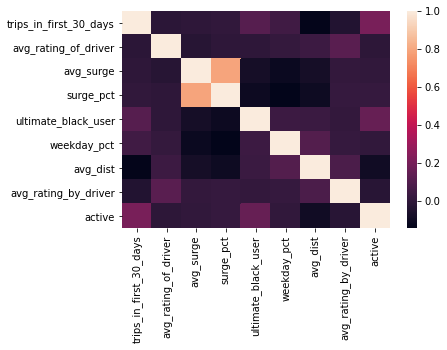

In [36]:
sns.heatmap(df.corr())

Looks like average distance and average ratings have the biggest impact

#### Categorical Feature EDA

In [41]:
city = pd.crosstab(index=df["active"], 
                            columns=df["city"],
                             margins=True)

city.columns = ["Astapor","King's Landing",'Winterfell', 'Total']
city.index= ["Inactive","Active", 'Total']

city

,Astapor,King's Landing,Winterfell,Total
Inactive,13838,6099,17865,37802
Active,2696,4031,5471,12198
Total,16534,10130,23336,50000


Looks like King's Landing has the highest percentage of active users and Astapor has the lowest percentage of active users.

In [42]:
phone = pd.crosstab(index=df["active"], 
                            columns=df["phone"],
                             margins=True)

phone.columns = ["Android","iPhone",'Total']
phone.index= ["Inactive","Active", 'Total']

phone

,Android,iPhone,Total
Inactive,13096,24394,37490
Active,1926,10188,12114
Total,15022,34582,49604


Looks like iPhone users are much more likely to be active than Android users

In [43]:
black = pd.crosstab(index=df["active"], 
                            columns=df["ultimate_black_user"],
                             margins=True)

black.columns = ["True","False",'Total']
black.index= ["Inactive","Active", 'Total']

black

,True,False,Total
Inactive,25204,12598,37802
Active,5942,6256,12198
Total,31146,18854,50000


Ultimate Black users are half as likely to be active as none Ultimate Black users

#### Numerical Feature EDA

In [44]:
active = df[df['active']==1]
inactive = df[df['active']==0]

(array([9041., 1965.,  629.,  303.,  127.,   73.]),
 array([ 0.,  5., 10., 15., 20., 25., 30.]),
 <BarContainer object of 6 artists>)

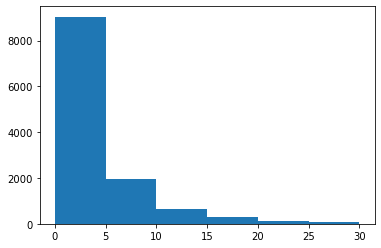

In [50]:
plt.hist(active['trips_in_first_30_days'], bins=6, range=(0,30))

(array([34209.,  2664.,   557.,   222.,    76.,    39.]),
 array([ 0.,  5., 10., 15., 20., 25., 30.]),
 <BarContainer object of 6 artists>)

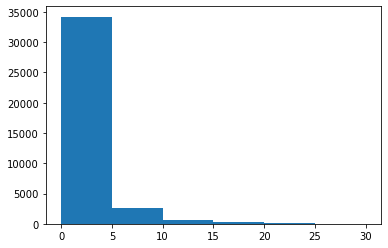

In [51]:
plt.hist(inactive['trips_in_first_30_days'], bins=6, range=(0,30))

Inactive users were more likely to have taken fewer trips in the first 30 days than active users, as expected

(array([2.200e+01, 1.000e+00, 2.600e+01, 2.500e+01, 3.200e+01, 3.230e+02,
        4.940e+02, 1.099e+03, 1.889e+03, 7.414e+03]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

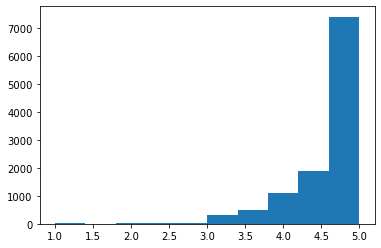

In [52]:
plt.hist(active['avg_rating_of_driver'])

(array([2.3400e+02, 6.0000e+00, 1.9200e+02, 9.5000e+01, 6.8000e+01,
        1.0810e+03, 9.5800e+02, 3.7470e+03, 3.5260e+03, 2.0646e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

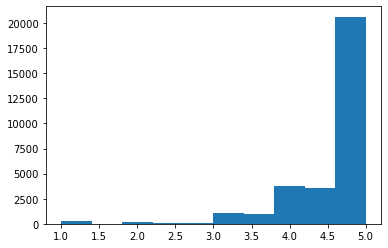

In [53]:
plt.hist(inactive['avg_rating_of_driver'])

Looks like inactive and active users both tended to give high ratings to drivers

(array([1.2000e+01, 0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00,
        4.9000e+01, 9.7000e+01, 2.7900e+02, 1.5220e+03, 1.0211e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

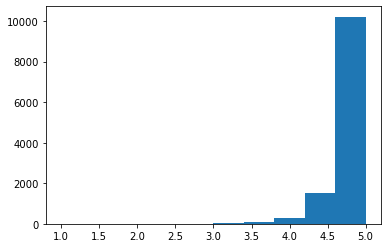

In [54]:
plt.hist(active['avg_rating_by_driver'])

(array([1.6900e+02, 4.0000e+00, 1.2000e+02, 3.2000e+01, 5.0000e+00,
        6.0700e+02, 4.2700e+02, 1.8010e+03, 3.1220e+03, 3.1336e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

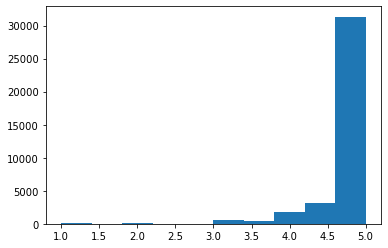

In [55]:
plt.hist(inactive['avg_rating_by_driver'])

There's not much of a correlation here either; just about every driver gave their passenger 5 stars

(array([8.011e+03, 2.134e+03, 1.126e+03, 4.130e+02, 1.180e+02, 2.180e+02,
        4.600e+01, 7.000e+00, 3.000e+00, 1.220e+02]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

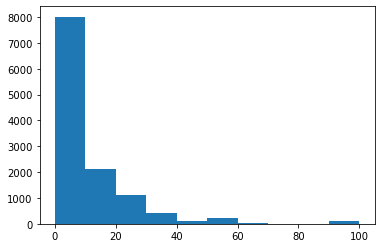

In [56]:
plt.hist(active['surge_pct'])

(array([3.0037e+04, 1.9980e+03, 1.7240e+03, 1.1120e+03, 2.3600e+02,
        1.1870e+03, 1.6900e+02, 3.2000e+01, 1.3000e+01, 1.2940e+03]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

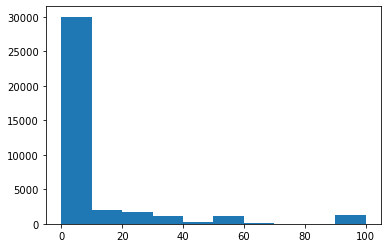

In [57]:
plt.hist(inactive['surge_pct'])

People who paid surge prices of 10% or greater were much more likely to be active users

(array([1.1863e+04, 3.1600e+02, 1.4000e+01, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.   ,  16.096,  32.192,  48.288,  64.384,  80.48 ,  96.576,
        112.672, 128.768, 144.864, 160.96 ]),
 <BarContainer object of 10 artists>)

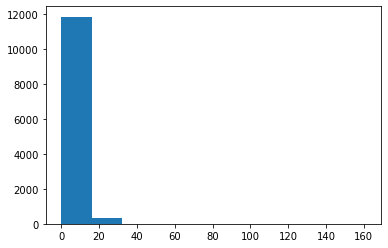

In [58]:
plt.hist(active['avg_dist'])

(array([3.3324e+04, 3.9050e+03, 4.5300e+02, 9.0000e+01, 2.3000e+01,
        5.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.   ,  12.989,  25.978,  38.967,  51.956,  64.945,  77.934,
         90.923, 103.912, 116.901, 129.89 ]),
 <BarContainer object of 10 artists>)

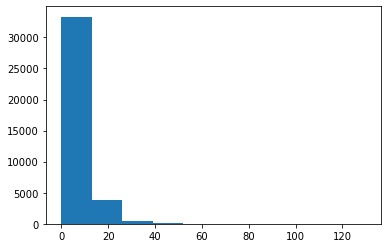

In [59]:
plt.hist(inactive['avg_dist'])

Users with an average distance greater than 10 were much more likely to be inactive

(array([ 895.,  193.,  518.,  808.,  955., 1988., 1998., 1438., 1113.,
        2292.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

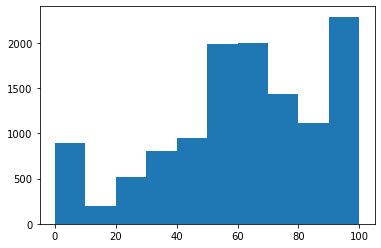

In [61]:
plt.hist(active['weekday_pct'])

(array([ 8349.,   310.,  1047.,  1611.,  1050.,  4110.,  2824.,  1827.,
         1537., 15137.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

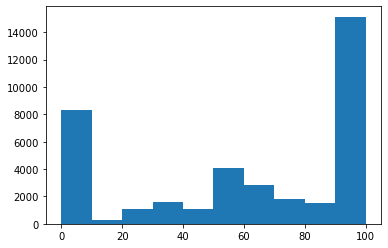

In [60]:
plt.hist(inactive['weekday_pct'])

The scaling makes this a little bit hard to read, but there's not much difference between active/inactive here

### Modeling

Since the categorical features are significantly better than the categorical features, I'm going to use a random forest model with dummy variables for the three categorical variables, along with engineered features that tell us whether trips_in_first_30_days, surge_pct and avg_dist were above a threshhold

In [66]:
df = df.dropna()
df = df.reset_index(drop = True)

In [69]:
df['high_initial_trips'] = np.where(df['trips_in_first_30_days']>4, 1, 0)

In [71]:
df['high_surge_pct'] = np.where(df['surge_pct']>9.0, 1, 0)

In [72]:
df['high_dist'] = np.where(df['avg_dist']>9.0, 1, 0)

In [74]:
df = df.drop(['trips_in_first_30_days','signup_date', 'avg_rating_of_driver', 'avg_surge','last_trip_date', 'surge_pct'
             , 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'], axis=1)

In [75]:
df['ultimate_black_user'] = (df['ultimate_black_user']).astype(int)

In [76]:
phone = pd.get_dummies(df['phone'])
city = pd.get_dummies(df['city'])

In [77]:
df = pd.concat([df, phone, city], axis=1)

In [78]:
df = df.drop(['phone', 'city'], axis=1)

In [79]:
df.head()

,ultimate_black_user,active,high_initial_trips,high_surge_pct,high_dist,Android,iPhone,Astapor,King's Landing,Winterfell
0,1,0,0,1,0,0,1,0,1,0
1,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,0,1,1,0,0
3,1,1,1,1,0,0,1,0,1,0
4,0,0,1,1,0,1,0,0,0,1


In [80]:
y = df['active']
X = df.drop('active', axis=1)

In [81]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y)

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 10}
Best average precision was 0.68146567027056


In [83]:
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy 0.679212507237985
              precision    recall  f1-score   support

           0       0.85      0.68      0.76      7572
           1       0.44      0.67      0.53      2790

    accuracy                           0.68     10362
   macro avg       0.64      0.68      0.64     10362
weighted avg       0.74      0.68      0.70     10362



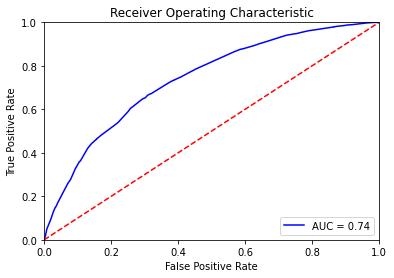

In [84]:
import sklearn.metrics as metrics
probs = model.predict_proba(Xtest)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [90]:
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

high_initial_trips     0.194968
ultimate_black_user    0.166752
King's Landing         0.121574
Android                0.117085
high_surge_pct         0.110468
iPhone                 0.107922
Astapor                0.080692
high_dist              0.067390
Winterfell             0.033149
dtype: float64


The most obvious recommendations are for Ultimate to look into why certain cities see higher retention than others, and look into why iPhone users are significantly more likely to use the product than Android users. Additionally, Ultimate should try to get more new signees to use the product frequently during their first 30 days